# Erstellung der Heatmaps

### Laden der Daten

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import configparser
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
from scipy.constants import e, c, h, nano
from scipy.signal import find_peaks
import os
import re
import pandas as pd
from scipy.special import wofz

plt.rcParams['text.usetex'] = True #LaTeX

In [4]:
data_20_20 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T20_I20.CSV', delimiter=",", skiprows=1)
t_20_20 = data_20_20[:, 0]
U_20_20 = data_20_20[:, 1]

data_20_25 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T20_I25.CSV', delimiter=",", skiprows=1)
t_20_25 = data_20_25[:, 0]
U_20_25 = data_20_25[:, 1]

data_20_30 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T20_I30.CSV', delimiter=",", skiprows=1)
t_20_30 = data_20_30[:, 0]
U_20_30 = data_20_30[:, 1]

data_20_35 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T20_I35.CSV', delimiter=",", skiprows=1)
t_20_35 = data_20_35[:, 0]
U_20_35 = data_20_35[:, 1]

##########################

data_25_20 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T25_I20.CSV', delimiter=",", skiprows=1)
t_25_20 = data_25_20[:, 0]
U_25_20 = data_25_20[:, 1]

data_25_25 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T25_I25.CSV', delimiter=",", skiprows=1)
t_25_25 = data_25_25[:, 0]
U_25_25 = data_25_25[:, 1]

data_25_30 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T25_I30.CSV', delimiter=",", skiprows=1)
t_25_30 = data_25_30[:, 0]
U_25_30 = data_25_30[:, 1]

data_25_35 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T25_I35.CSV', delimiter=",", skiprows=1)
t_25_35 = data_25_35[:, 0]
U_25_35 = data_25_35[:, 1]

###########################

data_30_20 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T30_I20.CSV', delimiter=",", skiprows=1)
t_30_20 = data_30_20[:, 0]
U_30_20 = data_30_20[:, 1]

data_30_25 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T30_I25.CSV', delimiter=",", skiprows=1)
t_30_25 = data_30_25[:, 0]
U_30_25 = data_30_25[:, 1]

data_30_30 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T30_I30.CSV', delimiter=",", skiprows=1)
t_30_30 = data_30_30[:, 0]
U_30_30 = data_30_30[:, 1]

data_30_35 = np.loadtxt('/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/T30_I35.CSV', delimiter=",", skiprows=1)
t_30_35 = data_30_35[:, 0]
U_30_35 = data_30_35[:, 1]

### Umrechnungsfaktor einfügen

In [5]:
faktor = 634.84063048 / 0.02603864

### Main Code 

#### Einstellungen

In [6]:
# === Einstellungen ===
data_dir = '/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data'
output_file = 'ausgewertete_peaks.csv'
delta_t = 0.00634  # z.B. 6.34 ms = Abstand zwischen Peaks in Referenzdatei
FSR = 634  # in GHz
faktor = FSR / delta_t  # GHz pro Sekunde

#### Voigit Profil -> Kombination aus Lorenzt und Gauß

In [7]:
def voigt(x, amp, mu, sigma, gamma, offset):
    z = ((x - mu) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi)) + offset



#### Einzelnes Spektrum analysieren

In [8]:
def analyze_spectrum(filepath):
    data = np.loadtxt(filepath, delimiter=",", skiprows=1)
    t = data[:, 0]
    U = data[:, 1]
    f = (t - t[0]) * faktor  # Frequenzachse mit Start bei 0

    # Zwei Peaks finden (grob)
    peak_inds = np.argsort(U)[-2:]  # zwei größte Werte
    guess_peaks = np.sort(f[peak_inds])  # grobe Startwerte für mu1, mu2

    # Startwerte für Voigt-Peak-Fits
    guesses = []
    for mu in guess_peaks:
        amp = max(U)
        sigma = 0.5
        gamma = 0.5
        offset = min(U)
        guesses.append((amp, mu, sigma, gamma, offset))

    results = []

    # Für jeden Peak einzeln fitten
    for i, guess in enumerate(guesses):
        # enger Bereich um den Peak
        mask = (f > guess[1] - 10) & (f < guess[1] + 10)
        try:
            popt, _ = curve_fit(voigt, f[mask], U[mask], p0=guess, maxfev=5000)
            amp, mu, sigma, gamma, offset = popt
            FWHM = 0.5346 * 2*gamma + np.sqrt(0.2166 * (2*gamma)**2 + (2.3548 * sigma)**2)
            results.append((mu, FWHM))
        except:
            results.append((np.nan, np.nan))

    return results

#### Alle Daten analysieren

In [9]:
all_results = []

for filename in os.listdir(data_dir):
    if filename.endswith(".CSV"):
        filepath = os.path.join(data_dir, filename)

        # Temperatur und Strom extrahieren
        match = re.search(r'T(\d+)_I(\d+)', filename)
        if not match:
            continue
        T = int(match.group(1))
        I = int(match.group(2))

        peaks = analyze_spectrum(filepath)
        row = {
            'Datei': filename,
            'Temperatur (°C)': T,
            'Strom (mA)': I,
            'Peak1_Frequenz (GHz)': peaks[0][0],
            'Peak1_FWHM (GHz)': peaks[0][1],
            'Peak2_Frequenz (GHz)': peaks[1][0],
            'Peak2_FWHM (GHz)': peaks[1][1],
            'Peakabstand (GHz)': abs(peaks[1][0] - peaks[0][0]) if None not in peaks else np.nan
        }
        all_results.append(row)

#### Speichern der Ergebnisse

In [10]:
df = pd.DataFrame(all_results)
df = df.sort_values(by=['Temperatur (°C)', 'Strom (mA)'])
df.to_csv(os.path.join(data_dir, output_file), index=False)
print(f'✅ Analyse abgeschlossen! Ergebnisse gespeichert in: {output_file}')

✅ Analyse abgeschlossen! Ergebnisse gespeichert in: ausgewertete_peaks.csv


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Verzeichnis, in dem deine CSV-Dateien liegen
data_dir = '/Users/zarahaigner/Documents/Physik_6 Semester/Fortgeschrittenes Praktikum/Diodenlaser/data/'

# Liste der Dateinamen
files = sorted([f for f in os.listdir(data_dir) if f.endswith('.CSV')])

# >>> Umrechnungsfaktor berechnen aus deinem bekannten delta_t (z. B. 0.00529s aus Aufgabe 2)
delta_t = 0.02603864  # Sekunden – dein gemessener Zeitabstand zwischen Peaks
FSR = 634  # in GHz
faktor = FSR / delta_t  # GHz / s

# Gaußfunktion
def gauss(x, a, mu, sigma, c):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

# Ergebnisse speichern
results = []

for filename in files:
    filepath = os.path.join(data_dir, filename)
    data = np.loadtxt(filepath, delimiter=",", skiprows=1)
    t = data[:, 0]
    U = data[:, 1]

    # Frequenz-Achse berechnen
    f = (t - t[0]) * faktor

    # Suche grob nach Peaks (die zwei höchsten Werte im Signal)
    peak_indices = np.argsort(U)[-2:]  # zwei größte Werte
    peak_indices = np.sort(peak_indices)  # aufsteigend sortieren

    if len(peak_indices) < 2:
        print(f"Weniger als 2 Peaks in {filename} gefunden!")
        continue

    fit_data = []
    for i in range(2):
        center = peak_indices[i]
        window = 50  # Anzahl Punkte um den Peak zum Fitten
        start = max(center - window, 0)
        end = min(center + window, len(f))

        try:
            popt, _ = curve_fit(gauss, f[start:end], U[start:end],
                                p0=[np.max(U[start:end]) - np.min(U[start:end]),
                                    f[center],
                                    5,
                                    np.min(U[start:end])])
            amplitude, mu, sigma, offset = popt
            fwhm = 2.3548 * abs(sigma)  # Umrechnungsformel für Gauß

            fit_data.append((mu, fwhm))
        except RuntimeError:
            print(f"Fit fehlgeschlagen für {filename} bei Peak {i+1}")
            fit_data.append((np.nan, np.nan))

    # Informationen aus dem Dateinamen extrahieren
    parts = filename.replace('.CSV', '').split('_')
    temp = int(parts[0][1:])  # z.B. "T20" -> 20
    current = int(parts[1][1:])  # z.B. "I25" -> 25

    if len(fit_data) == 2:
        mu1, fwhm1 = fit_data[0]
        mu2, fwhm2 = fit_data[1]
        delta_f = abs(mu2 - mu1)
    else:
        mu1 = fwhm1 = mu2 = fwhm2 = delta_f = np.nan

    results.append({
        'Datei': filename,
        'Temperatur (°C)': temp,
        'Strom (mA)': current,
        'Peak1_Frequenz (GHz)': mu1,
        'Peak1_FWHM (GHz)': fwhm1,
        'Peak2_Frequenz (GHz)': mu2,
        'Peak2_FWHM (GHz)': fwhm2,
        'Peakabstand (GHz)': delta_f
    })

# In DataFrame umwandeln
df = pd.DataFrame(results)
print("Spaltennamen im DataFrame:", df.columns.tolist())
df = df.sort_values(by=[df.columns[1], df.columns[2]])  # also: nach Temperatur und Strom


#df = df.sort_values(by=['Temperatur (°C)', 'Strom (mA)'])

# Tabelle anzeigen
print(df)

# Tabelle als CSV speichern
df.to_csv('auswertung_peaks.csv', index=False)


Spaltennamen im DataFrame: ['Datei', 'Temperatur (°C)', 'Strom (mA)', 'Peak1_Frequenz (GHz)', 'Peak1_FWHM (GHz)', 'Peak2_Frequenz (GHz)', 'Peak2_FWHM (GHz)', 'Peakabstand (GHz)']
          Datei  Temperatur (°C)  Strom (mA)  Peak1_Frequenz (GHz)  \
0   T20_I20.CSV               20          20            493.826823   
1   T20_I25.CSV               20          25            321.686411   
2   T20_I30.CSV               20          30            289.767464   
3   T20_I35.CSV               20          35            155.966480   
4   T25_I20.CSV               25          20            388.249902   
5   T25_I25.CSV               25          25             86.327754   
6   T25_I30.CSV               25          30            469.837048   
7   T25_I35.CSV               25          35            459.788135   
8   T30_I20.CSV               30          20            949.071787   
9   T30_I25.CSV               30          25            794.676130   
10  T30_I30.CSV               30          30       

In [23]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Beispiel für das Filtern und Umstrukturieren der Daten für die Heatmap
# Angenommen, df ist die DataFrame-Tabelle, die die Peaks und deren Frequenzen enthält

# Erstellen einer Pivot-Tabelle für die Heatmap (Peak1_Frequenz)
heatmap_data1 = df.pivot_table(index='Temperatur (°C)', columns='Strom (mA)', values='Peak1_Frequenz (GHz)', aggfunc='mean')

# Erstellen einer Pivot-Tabelle für die Heatmap (Peak2_Frequenz)
heatmap_data2 = df.pivot_table(index='Temperatur (°C)', columns='Strom (mA)', values='Peak2_Frequenz (GHz)', aggfunc='mean')

# Optional: Berechnung des Abstandes der Peaks (Delta_f)
heatmap_delta_f = df.pivot_table(index='Temperatur (°C)', columns='Strom (mA)', values='Peakabstand (GHz)', aggfunc='mean')


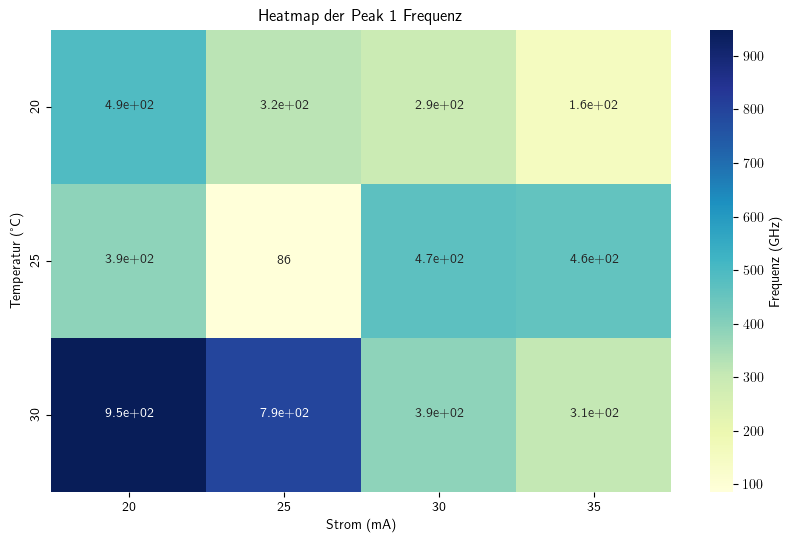

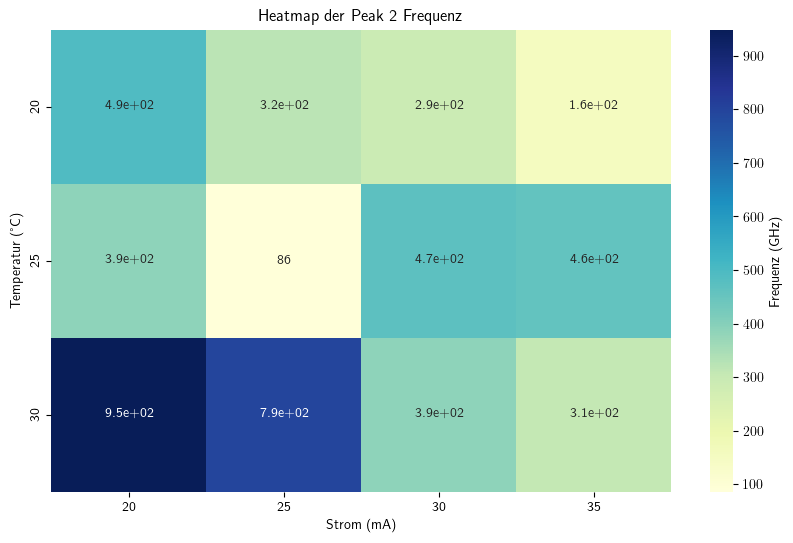

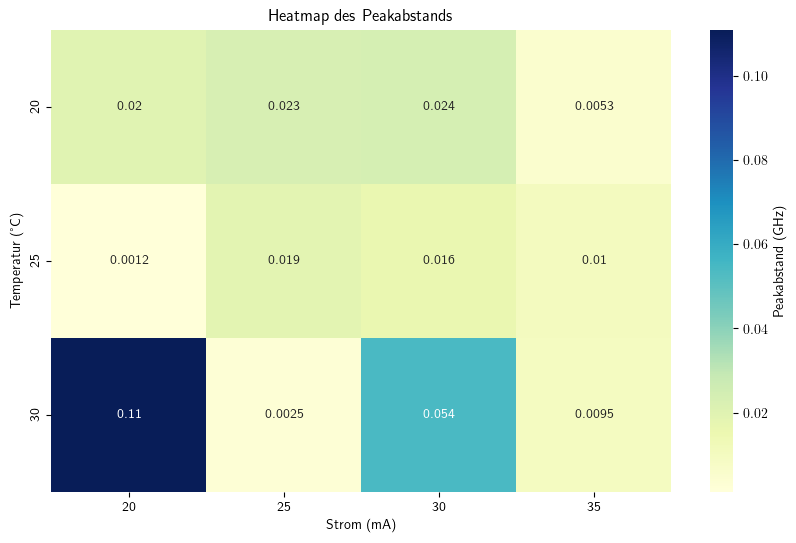

In [25]:
# Heatmap für Peak1_Frequenz erstellen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data1, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Frequenz (GHz)'})
plt.title('Heatmap der Peak 1 Frequenz')
plt.xlabel('Strom (mA)')
plt.ylabel('Temperatur (°C)')
plt.show()

# Heatmap für Peak2_Frequenz erstellen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data2, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Frequenz (GHz)'})
plt.title('Heatmap der Peak 2 Frequenz')
plt.xlabel('Strom (mA)')
plt.ylabel('Temperatur (°C)')
plt.show()

# Optional: Heatmap für den Peakabstand erstellen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_delta_f, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Peakabstand (GHz)'})
plt.title('Heatmap des Peakabstands')
plt.xlabel('Strom (mA)')
plt.ylabel('Temperatur (°C)')
plt.show()


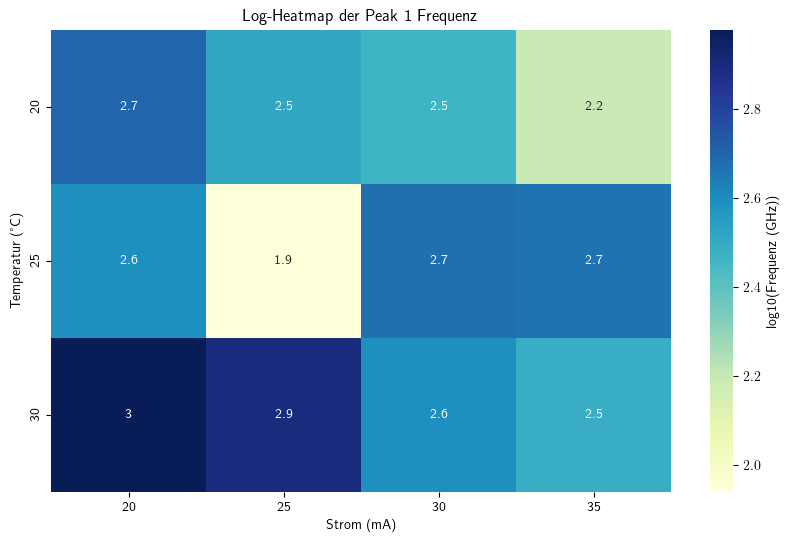

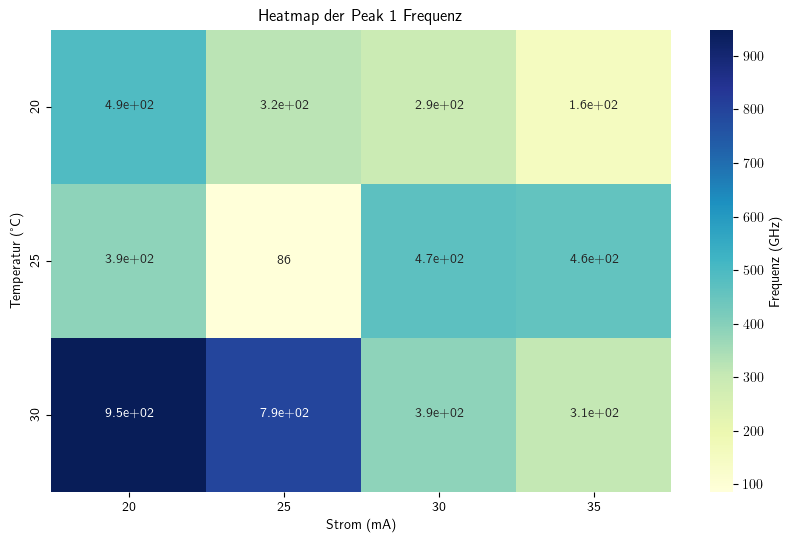

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Beispiel: Normalisierung der Daten oder Log-Skalierung
# Die Funktion np.log10 wird verwendet, um Werte auf einer logarithmischen Skala darzustellen
heatmap_data1_log = np.log10(heatmap_data1 + 1)  # +1, um mit Nullwerten umzugehen

# Heatmap mit logarithmischer Skala
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data1_log, annot=True, cmap='YlGnBu', cbar_kws={'label': 'log10(Frequenz (GHz))'})
plt.title('Log-Heatmap der Peak 1 Frequenz')
plt.xlabel('Strom (mA)')
plt.ylabel('Temperatur (°C)')
plt.show()

# Alternativ könnte auch eine lineare Skala verwendet werden
# Wenn du eine lineare Darstellung bevorzugst, dann einfach die originalen Daten verwenden

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data1, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Frequenz (GHz)'})
plt.title('Heatmap der Peak 1 Frequenz')
plt.xlabel('Strom (mA)')
plt.ylabel('Temperatur (°C)')
plt.show()


# Peak Analyse